# Market Regime Detection using Hidden Markov Model

In this notebook, a Hidden Markov Model (HMM) is used to classify the market into different regimes.

The regimes represent underlying market states such as uptrend, downtrend, and sideways movement, which are not directly observable.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn.hmm import GaussianHMM


In [2]:
features = pd.read_csv("../data/nifty_features_5min.csv")
features["timestamp"] = pd.to_datetime(features["timestamp"])
features.head()


,timestamp,open,high,low,close,volume,ema_5,ema_15,spot_return,futures_basis,avg_iv,iv_spread,pcr_oi,pcr_volume
0,2015-01-09 09:20:00,8300.50,8303.00,8293.25,8301.00,0,8301.133333,8301.175000,-0.000024,0.0005,0.209528,-0.001660,1.215374,0.941080
1,2015-01-09 09:25:00,8301.65,8302.55,8286.80,8294.15,0,8298.805556,8300.296875,-0.000826,0.0005,0.187823,-0.012707,3.066087,0.621079
2,2015-01-09 09:30:00,8294.10,8295.75,8280.65,8288.50,0,8295.370370,8298.822266,-0.000681,0.0005,0.191463,-0.024234,0.516905,0.395105
3,2015-01-09 09:35:00,8289.10,8290.45,8278.00,8283.45,0,8291.396914,8296.900732,-0.000609,0.0005,0.173081,0.045038,2.092148,4.619883
4,2015-01-09 09:40:00,8283.40,8288.30,8277.40,8285.55,0,8289.447942,8295.481891,0.000253,0.0005,0.225163,-0.020501,2.222767,0.645333


## HMM Input Features

The HMM is trained using a subset of options-based and volatility-related features to avoid direct price leakage.


In [3]:
hmm_features = features[
    [
        "avg_iv",
        "iv_spread",
        "pcr_oi",
        "pcr_volume",
        "futures_basis",
        "spot_return"
    ]
].dropna()

hmm_features.head()


,avg_iv,iv_spread,pcr_oi,pcr_volume,futures_basis,spot_return
0,0.209528,-0.001660,1.215374,0.941080,0.0005,-0.000024
1,0.187823,-0.012707,3.066087,0.621079,0.0005,-0.000826
2,0.191463,-0.024234,0.516905,0.395105,0.0005,-0.000681
3,0.173081,0.045038,2.092148,4.619883,0.0005,-0.000609
4,0.225163,-0.020501,2.222767,0.645333,0.0005,0.000253


## Train-Test Split

The model is trained on the first 70% of the data and evaluated on the remaining 30%.


In [4]:
split_idx = int(len(hmm_features) * 0.7)

train_data = hmm_features.iloc[:split_idx]
test_data = hmm_features.iloc[split_idx:]


## HMM Training

A 3-state Gaussian HMM is used to model different market regimes.


In [5]:
hmm = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=200,
    random_state=42
)

hmm.fit(train_data)


,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [6]:
features["regime"] = hmm.predict(hmm_features)
features["regime"].value_counts()


regime
2    173163
1     18745
0      3171
Name: count, dtype: int64

## Regime Interpretation

Each HMM state is mapped to a market regime based on the average spot return.


In [7]:
regime_returns = features.groupby("regime")["spot_return"].mean()
regime_returns


regime
0    0.000215
1   -0.000001
2    0.000003
Name: spot_return, dtype: float64

In [10]:
regime_map = {}

for regime, ret in regime_returns.items():
    if ret > 0:
        regime_map[regime] = 1   # Uptrend
    elif ret < 0:
        regime_map[regime] = -1  # Downtrend
    else:
        regime_map[regime] = 0   # Sideways

features["market_regime"] = features["regime"].map(regime_map)
# Save features with market regime
features.to_csv("../data/nifty_features_5min.csv", index=False)

features[["timestamp", "market_regime"]].head()


,timestamp,market_regime
0,2015-01-09 09:20:00,1
1,2015-01-09 09:25:00,1
2,2015-01-09 09:30:00,1
3,2015-01-09 09:35:00,-1
4,2015-01-09 09:40:00,1


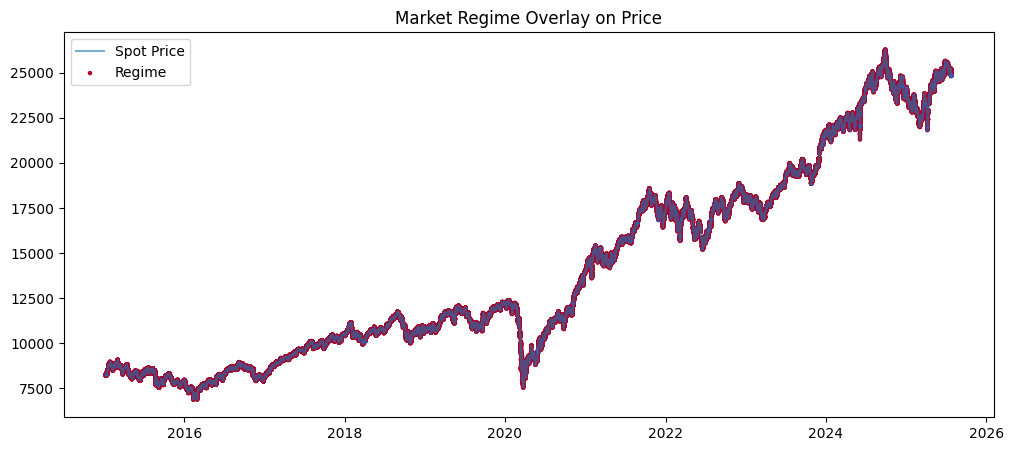

In [11]:
plt.figure(figsize=(12, 5))

plt.plot(features["timestamp"], features["close"], label="Spot Price", alpha=0.6)

plt.scatter(
    features["timestamp"],
    features["close"],
    c=features["market_regime"],
    cmap="coolwarm",
    s=5,
    label="Regime"
)

plt.title("Market Regime Overlay on Price")
plt.legend()
plt.show()


## Regime Detection Notes

- HMM captures probabilistic regime transitions.
- Regime labels are interpreted post-training using average returns.
- The model is not tuned aggressively to avoid overfitting.
- Regime predictions are used as a filter for trading strategies.
